In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math

# Univariate Time Series: predict tomorrow’s btc price based on last 10 days prices


In [23]:
# Fetching data

df = pd.read_csv('../data/dataset.csv')

<AxesSubplot:xlabel='Time'>

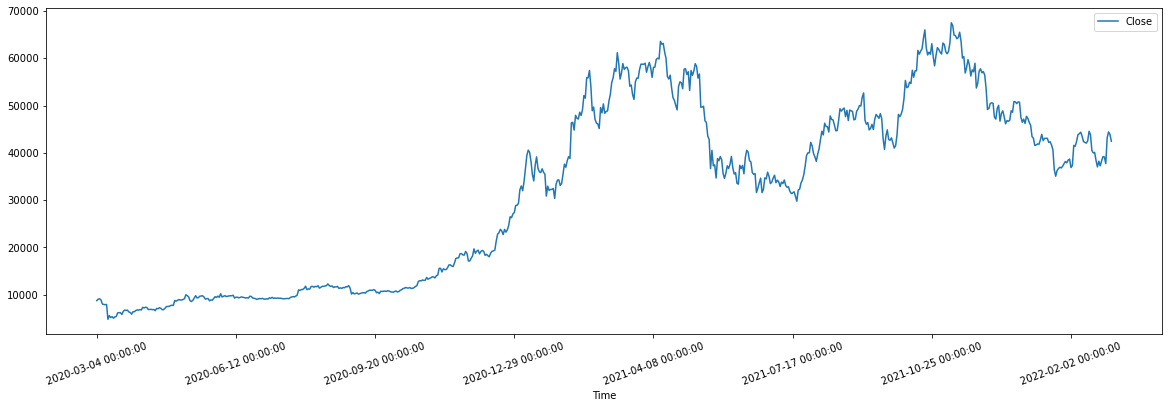

In [24]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

## Feature Scaling

In [25]:
# Extracting closing prices
FullData=df[['Close']].values
print(FullData[0:5])
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[8750.7]
 [9056.9]
 [9134.3]
 [8889.9]
 [8036.5]]
### After Normalization ###


array([[0.06295669],
       [0.06783975],
       [0.06907407],
       [0.06517655],
       [0.05156714]])

In [26]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=5  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(725, 5, 1)

#### Output Data shape ####
(725, 1)


## Test-Train Split

In [34]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

############################################

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)



#### Training Data shape ####
(720, 5, 1)
(720, 1)

#### Testing Data shape ####
(5, 5, 1)
(5, 1)

#### Training Data shape ####
(720, 5, 1)
(720, 1)

#### Testing Data shape ####
(5, 5, 1)
(5, 1)
[[[0.06295669]
  [0.06783975]
  [0.06907407]
  [0.06517655]
  [0.05156714]]

 [[0.06783975]
  [0.06907407]
  [0.06517655]
  [0.05156714]
  [0.04988949]]

 [[0.06907407]
  [0.06517655]
  [0.05156714]
  [0.04988949]
  [0.04931538]]

 ...

 [[0.5626808 ]
  [0.53546357]
  [0.51386616]
  [0.5330651 ]
  [0.51741284]]

 [[0.53546357]
  [0.51386616]
  [0.5330651 ]
  [0.51741284]
  [0.53452109]]

 [[0.51386616]
  [0.5330651 ]
  [0.51741284]
  [0.53452109]
  [0.54885291]]]


In [7]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.06295669]
 [0.06783975]
 [0.06907407]
 [0.06517655]
 [0.05156714]] -- [0.04988949]
[[0.06783975]
 [0.06907407]
 [0.06517655]
 [0.05156714]
 [0.04988949]] -- [0.04931538]


In [8]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 5
Number of Features: 1


In [9]:
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

2022-03-27 12:31:07.996131: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
144/144 [==============================] - 2s 3ms/step - loss: 0.1157
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 7/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 8/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 10/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 11/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 12/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/100


Accuracy: 93.9243562712295


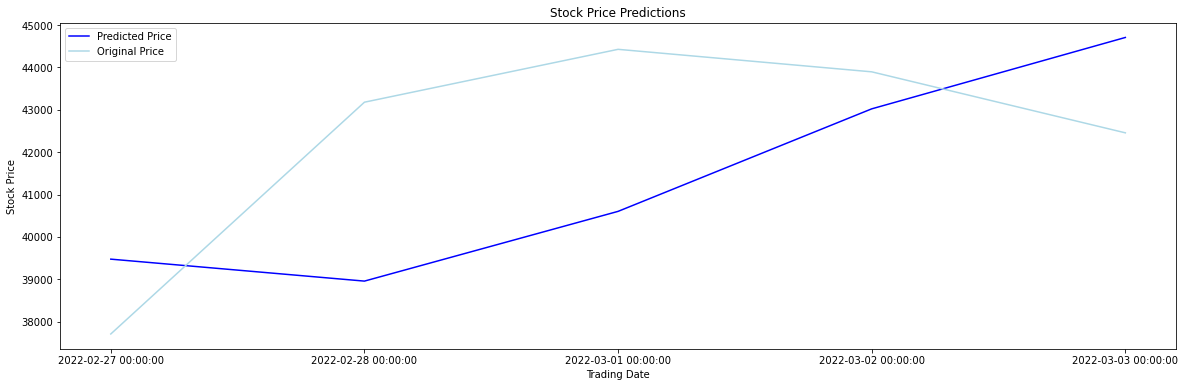

In [10]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), df.tail(TestingRecords)['Time'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

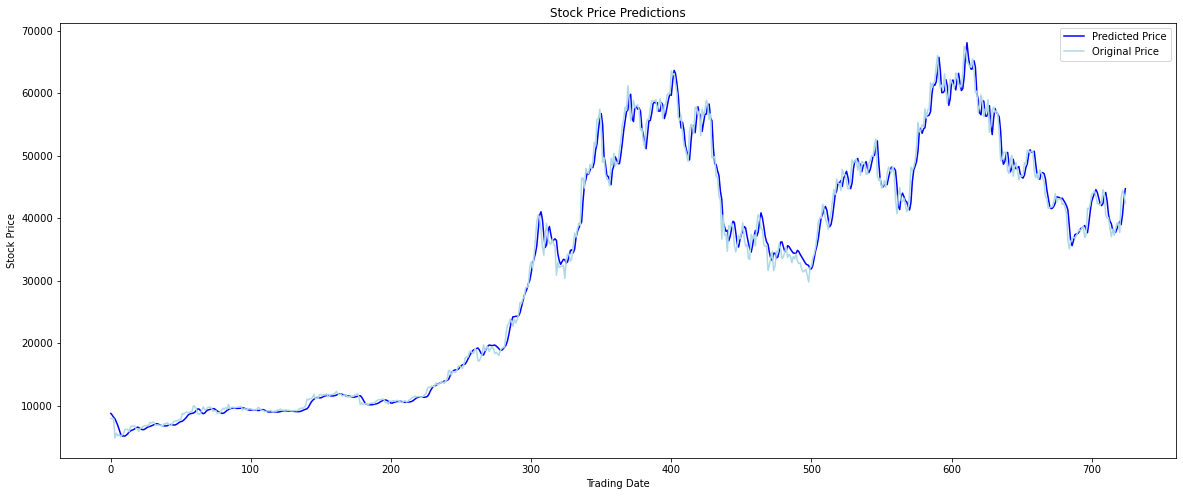

In [21]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [20]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(orig, predicted_Price))
print("RMSE on dev set = %0.3f" % rmse)

# Calculate MAPE
mape = get_mape(orig, predicted_Price)
print("MAPE on dev set = %0.3f%%" % mape)

RMSE on dev set = 2879.116
MAPE on dev set = 6.076%


# Third Model

In [3]:
df = pd.read_csv('../data/dataset.csv')

In [4]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isna().values.any())

Dataframe Shape:  (730, 12)
Null Value Present:  True


In [5]:
# Count missing value
print(df.isna().sum())

Time                       0
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
Close_mean                 1
Close_std                  2
dtype: int64


<AxesSubplot:xlabel='Time'>

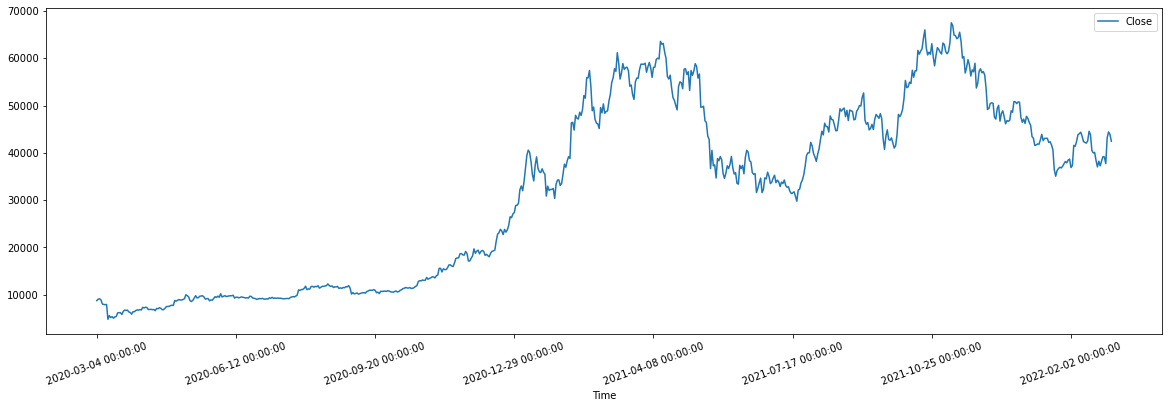

In [6]:
# Plotting the stock prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [7]:
#Set Target Variable
output_var = pd.DataFrame(df["Close"])
#Selecting the Features
features = ["Compound", "Volume", "FundingRate", "Bitcoin_SVI", "Cryptocurrency_SVI", \
           "No. of Active Addresses", "No. of Unique Addresses", "Transactions"]
# time_var = output_var = pd.DataFrame(df["Time"])

In [8]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Compound,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,0.6616,0.006956,0.406593,0.070506,0.040714,0.399875,0.429122,0.844827
1,0.6616,0.010453,0.428571,0.076814,0.034898,0.324190,0.392319,0.811569
2,0.6616,0.003008,0.439560,0.073660,0.030586,0.338011,0.388311,0.771346
3,0.6616,0.001482,0.494505,0.054838,0.027677,0.193585,0.257815,0.680871
4,0.6616,0.009495,0.516484,0.064198,0.040714,0.161141,0.213671,0.642553


In [12]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [13]:
X_train.shape

(664, 8)

In [14]:
y_train.shape

(664,)

In [15]:
from sklearn.impute import KNNImputer

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train)
X_train = pd.DataFrame(KNN_miss_filling.transform(X_train))

In [16]:
# Count missing value
print(X_train.isna().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


In [17]:
print(X_train.shape)
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)

(664, 8)
(664, 1, 8)


In [18]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2022-04-02 21:55:38.160596: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
83/83 [==============================] - 1s 1ms/step - loss: 1344723968.0000
Epoch 2/100
83/83 [==============================] - 0s 1ms/step - loss: 1344642560.0000
Epoch 3/100
83/83 [==============================] - 0s 999us/step - loss: 1344444544.0000
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 1344080640.0000
Epoch 5/100
83/83 [==============================] - 0s 997us/step - loss: 1343552640.0000
Epoch 6/100
83/83 [==============================] - 0s 1ms/step - loss: 1342884608.0000
Epoch 7/100
83/83 [==============================] - 0s 1ms/step - loss: 1342100480.0000
Epoch 8/100
83/83 [==============================] - 0s 961us/step - loss: 1341216000.0000
Epoch 9/100
83/83 [==============================] - 0s 968us/step - loss: 1340241152.0000
Epoch 10/100
83/83 [==============================] - 0s 956us/step - loss: 1339181952.0000
Epoch 11/100
83/83 [==============================] - 0s 1ms/step - loss: 1338042752.0000
Epoch 12/

83/83 [==============================] - 0s 1ms/step - loss: 1091814912.0000
Epoch 92/100
83/83 [==============================] - 0s 1ms/step - loss: 1087503232.0000
Epoch 93/100
83/83 [==============================] - 0s 982us/step - loss: 1083173632.0000
Epoch 94/100
83/83 [==============================] - 0s 972us/step - loss: 1078825984.0000
Epoch 95/100
83/83 [==============================] - 0s 985us/step - loss: 1074461184.0000
Epoch 96/100
83/83 [==============================] - 0s 976us/step - loss: 1070079296.0000
Epoch 97/100
83/83 [==============================] - 0s 976us/step - loss: 1065680896.0000
Epoch 98/100
83/83 [==============================] - 0s 952us/step - loss: 1061266816.0000
Epoch 99/100
83/83 [==============================] - 0s 958us/step - loss: 1056836608.0000
Epoch 100/100
83/83 [==============================] - 0s 973us/step - loss: 1052391232.0000


In [38]:
#LSTM Prediction
y_pred = lstm.predict(X_test)

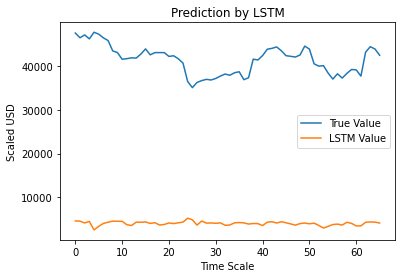

In [39]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [40]:
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(y_test-y_pred)/y_test)).mean())

Accuracy: 9.797959624738539


# Fourth Model

In [125]:
df = pd.read_csv('../data/dataset.csv')

In [126]:
df1 = df['Close']

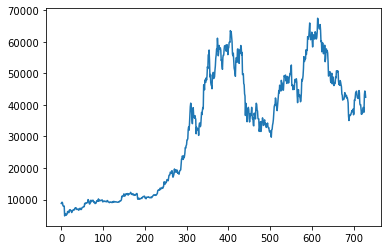

In [127]:
plt.plot(df1)

In [128]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [129]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [130]:
training_size,test_size

(510, 220)

In [131]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [132]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [133]:
print(X_train.shape), print(y_train.shape)

(409, 100)
(409,)


(None, None)

In [134]:
print(X_test.shape), print(ytest.shape)

(119, 100)
(119,)


(None, None)

In [135]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [136]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [137]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [138]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_18 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [139]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_18 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
7/7 [==============================] - 6s 255ms/step - loss: 0.0989 - val_loss: 0.0492
Epoch 2/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0176 - val_loss: 0.0321
Epoch 3/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0147 - val_loss: 0.0053
Epoch 4/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 5/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 6/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0053 - val_loss: 0.0082
Epoch 7/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 8/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 9/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 10/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 11/100
7/7 [

In [141]:
import tensorflow as tf

In [142]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [143]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [144]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

33543.8411781564

In [145]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

47085.46441652847

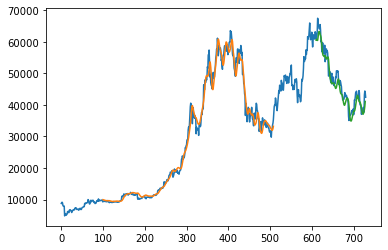

In [146]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [147]:
length = len(test_data) - 100
x_input=test_data[length:].reshape(1,-1)
x_input.shape

(1, 100)

In [148]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [149]:
x_input

array([[0.8345852 , 0.86353749, 0.78014754, 0.79595768, 0.83679549,
        0.84479943, 0.8312554 , 0.83539213, 0.82418278, 0.77866604,
        0.70747896, 0.71117235, 0.7278261 , 0.73005712, 0.72822319,
        0.68167785, 0.67509321, 0.71106869, 0.72164971, 0.668078  ,
        0.69454093, 0.70280481, 0.68288984, 0.65931497, 0.67014317,
        0.66780211, 0.67130414, 0.70309186, 0.69816255, 0.73411252,
        0.73362772, 0.72724402, 0.73307435, 0.73218449, 0.6816013 ,
        0.66441969, 0.67488111, 0.66043287, 0.68454836, 0.67758258,
        0.66405291, 0.65431868, 0.61642475, 0.61051309, 0.58619826,
        0.58809758, 0.59124079, 0.59026323, 0.60490762, 0.62376209,
        0.60227632, 0.61021328, 0.61032013, 0.6102978 , 0.59641728,
        0.59876153, 0.58786635, 0.57223801, 0.50476345, 0.48258716,
        0.50155327, 0.50827983, 0.51276899, 0.51045504, 0.51611633,
        0.5248682 , 0.53226774, 0.52756807, 0.53685577, 0.54046145,
        0.51160484, 0.5185738 , 0.5864901 , 0.58

In [150]:
# demonstrate prediction for next 14 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<14):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)


[0.62490463]
101
1 day input [0.86353749 0.78014754 0.79595768 0.83679549 0.84479943 0.8312554
 0.83539213 0.82418278 0.77866604 0.70747896 0.71117235 0.7278261
 0.73005712 0.72822319 0.68167785 0.67509321 0.71106869 0.72164971
 0.668078   0.69454093 0.70280481 0.68288984 0.65931497 0.67014317
 0.66780211 0.67130414 0.70309186 0.69816255 0.73411252 0.73362772
 0.72724402 0.73307435 0.73218449 0.6816013  0.66441969 0.67488111
 0.66043287 0.68454836 0.67758258 0.66405291 0.65431868 0.61642475
 0.61051309 0.58619826 0.58809758 0.59124079 0.59026323 0.60490762
 0.62376209 0.60227632 0.61021328 0.61032013 0.6102978  0.59641728
 0.59876153 0.58786635 0.57223801 0.50476345 0.48258716 0.50155327
 0.50827983 0.51276899 0.51045504 0.51611633 0.5248682  0.53226774
 0.52756807 0.53685577 0.54046145 0.51160484 0.5185738  0.5864901
 0.58341387 0.59948873 0.62262665 0.62576826 0.63106435 0.61704031
 0.59909483 0.59673942 0.59409217 0.60171338 0.63407361 0.62299024
 0.56938664 0.56092341 0.5626808  0.

10 day output [[0.65929574]]
11 day input [0.71117235 0.7278261  0.73005712 0.72822319 0.68167785 0.67509321
 0.71106869 0.72164971 0.668078   0.69454093 0.70280481 0.68288984
 0.65931497 0.67014317 0.66780211 0.67130414 0.70309186 0.69816255
 0.73411252 0.73362772 0.72724402 0.73307435 0.73218449 0.6816013
 0.66441969 0.67488111 0.66043287 0.68454836 0.67758258 0.66405291
 0.65431868 0.61642475 0.61051309 0.58619826 0.58809758 0.59124079
 0.59026323 0.60490762 0.62376209 0.60227632 0.61021328 0.61032013
 0.6102978  0.59641728 0.59876153 0.58786635 0.57223801 0.50476345
 0.48258716 0.50155327 0.50827983 0.51276899 0.51045504 0.51611633
 0.5248682  0.53226774 0.52756807 0.53685577 0.54046145 0.51160484
 0.5185738  0.5864901  0.58341387 0.59948873 0.62262665 0.62576826
 0.63106435 0.61704031 0.59909483 0.59673942 0.59409217 0.60171338
 0.63407361 0.62299024 0.56938664 0.56092341 0.5626808  0.53546357
 0.51386616 0.5330651  0.51741284 0.53452109 0.54885291 0.54725021
 0.52472626 0.6120073

In [151]:
day_new=np.arange(1,101)
day_pred=np.arange(101,115)

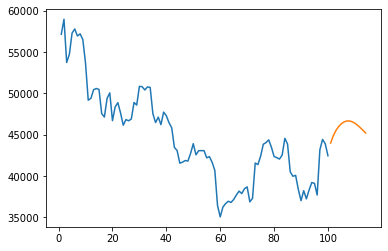

In [152]:
length = len(df1) - 100
plt.plot(day_new,scaler.inverse_transform(df1[630:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

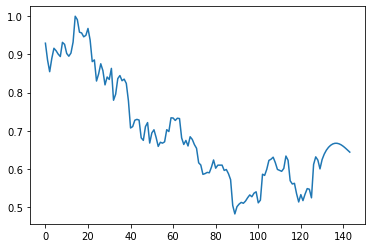

In [153]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[600:])

In [11]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

In [231]:
overall_df = pd.read_csv('../data/dataset.csv')
overall_df = overall_df.drop(['Time'], axis=1)
overall_df = overall_df.dropna()

In [232]:
print(overall_df.isna().sum())

Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64


## Scaling and Feature Selection

In [233]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(overall_df)

## Train, Validation, Test Data Split

In [234]:

def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [235]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [236]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(561, 25, 11)
(140, 25, 11)
(561, 1)
(140, 1)


In [237]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 25, 16)            1792      
                                                                 
 dropout_4 (Dropout)         (None, 25, 16)            0         
                                                                 
 lstm_19 (LSTM)              (None, 16)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


In [238]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
7/7 [==============================] - 6s 263ms/step - loss: 0.2370 - root_mean_squared_error: 0.4869 - val_loss: 0.1384 - val_root_mean_squared_error: 0.3720
Epoch 2/40
7/7 [==============================] - 0s 24ms/step - loss: 0.0720 - root_mean_squared_error: 0.2683 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 3/40
7/7 [==============================] - 0s 22ms/step - loss: 0.0274 - root_mean_squared_error: 0.1657 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 4/40
7/7 [==============================] - 0s 26ms/step - loss: 0.0335 - root_mean_squared_error: 0.1832 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1329
Epoch 5/40
7/7 [==============================] - 0s 27ms/step - loss: 0.0304 - root_mean_squared_error: 0.1742 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 6/40
7/7 [==============================] - 0s 32ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - val_loss: 0.0223 - val_root_mean_squared

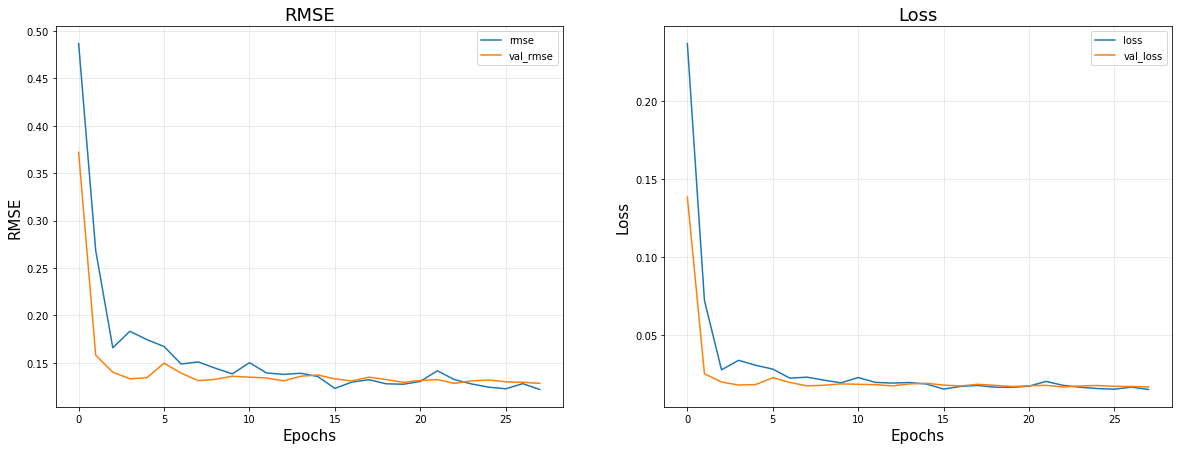

In [239]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


In [242]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))
        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        
        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))
        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist


In [245]:
import itertools
from keras.callbacks import ModelCheckpoint
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.05825, saving model to best_model.h5

Epoch 2: val_loss improved from 0.05825 to 0.04651, saving model to best_model.h5

Epoch 3: val_loss improved from 0.04651 to 0.02632, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.02632

Epoch 5: val_loss improved from 0.02632 to 0.02207, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.02207

Epoch 7: val_loss did not improve from 0.02207

Epoch 8: val_loss improved from 0.02207 to 0.01809, saving model to best_model.h5

Epoch 9: val_loss improved from 0.01809 to 0.01694, saving model to best_model.h5

Epoch 10: val_loss did not improve from 0.01694

Epoch 1

In [246]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
2,False,False,False,16,32,0.2,"[0.014986281283199787, 0.12241847068071365]","[0.02038479410111904, 0.14277532696723938]"
4,False,False,False,32,16,0.2,"[0.011189514771103859, 0.10578050464391708]","[0.02042861469089985, 0.14292870461940765]"
3,False,False,False,32,8,0.2,"[0.01462472788989544, 0.12093274295330048]","[0.020434236153960228, 0.14294837415218353]"
0,False,False,False,16,8,0.2,"[0.01053528394550085, 0.1026415303349495]","[0.02106431871652603, 0.1451355218887329]"
5,False,False,False,32,32,0.2,"[0.010339249856770039, 0.10168210417032242]","[0.021781256422400475, 0.1475847363471985]"
1,False,False,False,16,16,0.2,"[0.016087045893073082, 0.1268347203731537]","[0.026875123381614685, 0.16393634676933289]"


In [248]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

5/5 [==============================] - 0s 11ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525
test loss, test acc: [0.0233 0.1525]


In [249]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')


Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 32
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.1525

Results After Tunning:
 Test Set RMSE: 0.1428

6.0% Improvement


In [250]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [251]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.03498, saving model to best_model.h5

Epoch 2: val_loss improved from 0.03498 to 0.01686, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.01686

Epoch 4: val_loss did not improve from 0.01686

Epoch 5: val_loss did not improve from 0.01686

Epoch 6: val_loss did not improve from 0.01686

Epoch 7: val_loss did not improve from 0.01686
Epoch 7: early stopping


In [252]:
regressor.evaluate(X_test, y_test)

5/5 [==============================] - 0s 10ms/step - loss: 0.0223


0.0223357155919075

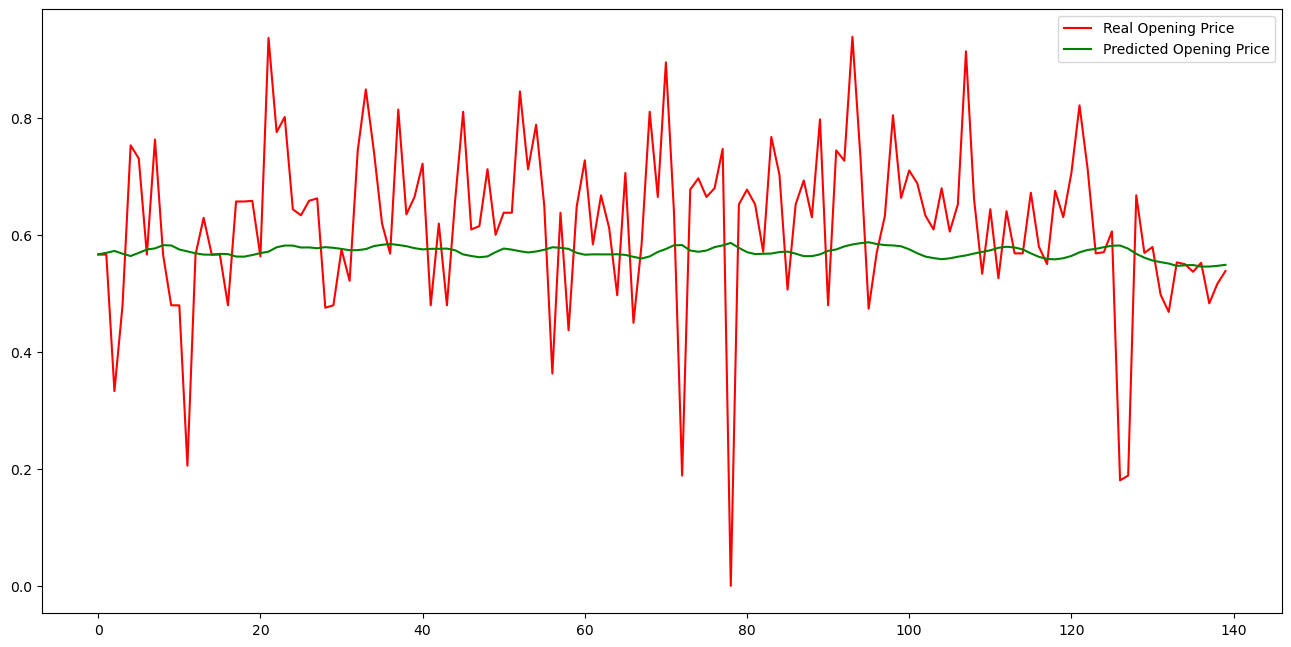

In [253]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')